# Conservation Analysis and Epitope Prediction


#### Author: C. Mazzaferro, K. Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: August 2016
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#ConsA">Conservation Analysis</a>
    * <a href = "#BLAST">BLAST-P</a>
    * <a href = "#MSA">Multiple Sequence Alignment</a>
    * <a href = "#Cons">Conservation Score Prediction</a>
3. <a href = "#ep_pred">Windowing and New Epitope Prediction</a>
    * <a href = "#clustering">Epitope Clustering Analysis</a>

Determine Cas9 orthologs that are orthogonal in the 'immunogenicity space'. This will allow us to prescribe a sequential regimen of Cas9s for therapeutic interventions. I've been thinking some more about how to do this, and I believe a simple strategy as follows might work:

- step i: build a database of Cas9 orthologs; #n.
- step ii: pick a seed Cas9 ortholog, say Sp, and then do a pairwise alignment with every other ortholog (n-1 alignments total). note that aligning all together will not be useful for our objective.
- step iii: overlay the immunogenicity profiles and score direct peptide overlaps (adding +1 for each overlap and 0 otherwise). sum the scores and retain orthologs (#m) for which the summation score = 0.
- step iv: randomly pick a second Cas9 from the orthologs retained in step iii and iterate back to step ii but now do just m-1 alignments with the retained orthologs. 

This should quickly converge and give a handful of orthologs. We should ideally be able to dial the immunogenicity thresholds in the workflow as we could potentially land up with too many or too few options. We might also get different orthogonal lists based on the choice of seed ortholog -- but their should still be substantial overlaps, and so we should ideally iterate through all orthologs in step i to establish robustness of the lists.

This is just a suggestion for a potential workflow, so let me know what you'll think and absolutely feel free to pick this apart!

Thanks!
Prashant

1. Run netMHCcons on full protein  DONE
2. Extract n-merized peptides   DONE
3. Calculate conservation score based on specific peptide   DONE
4. Peptide T-Cell receptor binding]    
5. Per Protein Metrics
 - high affinity peptides 
 - medium affinity peptides
 - "AVG" immunological values
    
    
>Summaries

>By protein

>Overall summary 


Screenshots
Peptide Summary: pep score affinty, verbal summary, high affinity and conserved/not conserved
Clustal Alignment with extra data (cons, affinity)
Clustal Alignment with the high affinity low conservation parts
Immunogenicity of potential "swap" parts

<a id = "background"></a>
# Background

CRISPR (clustered regularly interspaced short palindromic repeat) is an adaptive immune system that provides protection against mobile genetic elements (viruses, transposable elements and conjugative plasmids).
CRISPR clusters contain spacers, sequences complementary to antecedent mobile elements, and target invading nucleic acids. CRISPR clusters are transcribed and processed into CRISPR RNA (crRNA). In type II CRISPR systems correct processing of pre-crRNA requires a trans-encoded small RNA (tracrRNA), endogenous ribonuclease 3 (rnc) and this protein. The tracrRNA serves as a guide for ribonuclease 3-aided processing of pre-crRNA; Cas9 only stabilizes the pre-crRNA:tracrRNA interaction and has no catalytic function in RNA processing. Subsequently Cas9/crRNA/tracrRNA endonucleolytically cleaves linear or circular dsDNA target complementary to the spacer; Cas9 is inactive in the absence of the 2 guide RNAs (gRNA). The target strand not complementary to crRNA is first cut endonucleolytically, then trimmed 3'-5' exonucleolytically. DNA-binding requires protein and both gRNAs, as does nuclease activity. Cas9 recognizes the protospacer adjacent motif (PAM) in the CRISPR repeat sequences to help distinguish self versus nonself, as targets within the bacterial CRISPR locus do not have PAMs. DNA strand separation and heteroduplex formation starts at PAM sites; PAM recognition is required for catalytic activity (PubMed:24476820). Confers immunity against a plasmid with homology to the appropriate CRISPR spacer sequences (CRISPR interference) (PubMed:21455174)

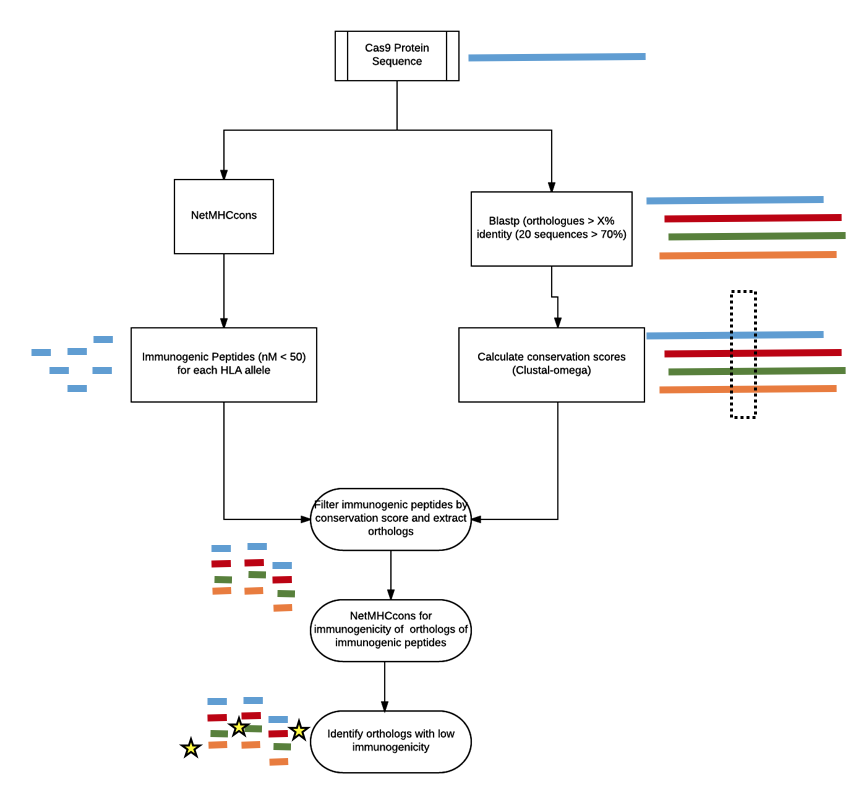

In [96]:
from IPython.display import Image
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/workflow_epitope.png")

The pipeline presented here is aimed at identify the most immunogenic peptides in Cas9. By looking at multiple sequence alignment scores for the possible peptides and their associated predicted MHC affinity, we can determine which peptides within a Cas9 orthologue can be swapped in order to reduce overall immunogenecity.

The steps are constructed as follows: 

1. Select proteins [from reference papaer](http://nar.oxfordjournals.org/content/suppl/2013/10/29/gkt1074.DC1/nar-02672-z-2013-File008.pdf)
2. Peform Multiple Sequence Alignement (MSA) using locally installed [Clustal Omega](http://www.clustal.org/omega/) in order to determine conservation scores
3. Calculate conservation scores for each n-mer (sizes 9, 10, 11) of the MSA
4. Predict the MHC affinity of each peptide using [CBS's prediction services](http://www.cbs.dtu.dk/services/), in particular [netMHCcons Server](http://www.cbs.dtu.dk/services/NetMHCcons/)
5. Output list of highly low-conservation, high affinity peptides for in-vitro research

<a id = "ConsA"></a>
# Conservation Analysis

The package nepitope is used as a "glue" between the steps involved in epitope prediction analysis. It was designed specifically to enable the user to run the steps outlined in "Background" and rendering the inputs and outputs of each program compatible for each step. 


<a id = "BLAST"></a>
## Protein Selection
Protein sequences were extracted from the paper referenced in bullet point #1

In [1]:
import glob
import pandas
from nepitope import preprocessing, scoring_utils
prots = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/study_pages/page*'

files = glob.glob(prots)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
ls_df = preprocessing.join_files(files)    
preprocessing.test_consistency(ls_df)

my_series = preprocessing.concat_dfs(ls_df)
preprocessing.test_series_consistency(my_series)

Grab extra data (motifs, JNET, secondary structure). Saved on file:  /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/extra_data_from_study.txt

In [3]:
extra_data = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/study_pages/extra_data_from_study.txt'
motifs, inf_pos = preprocessing.load_motifs_and_conservation_locs(extra_data)        

###  Dealign and rerun Clustal with reference protein sequence added

#### Write out as as single lines, dealign, add ref protein at the bottom

In [4]:
prop_form_fasta = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_proper.fasta'
Reference_Protein_name = '>StreptococcusPyogenes_reference'
Reference_Protein = 'MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRRKNRICYLQEIFSNEMAKVDDSFFHRLEESFLVEEDKKHERHPIFGNIVDEVAYHEKYPTIYHLRKKLVDSTDKADLRLIYLALAHMIKFRGHFLIEGDLNPDNSDVDKLFIQLVQTYNQLFEENPINASGVDAKAILSARLSKSRRLENLIAQLPGEKKNGLFGNLIALSLGLTPNFKSNFDLAEDAKLQLSKDTYDDDLDNLLAQIGDQYADLFLAAKNLSDAILLSDILRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFDQSKNGYAGYIDGGASQEEFYKFIKPILEKMDGTEELLVKLNREDLLRKQRTFDNGSIPHQIHLGELHAILRRQEDFYPFLKDNREKIEKILTFRIPYYVGPLARGNSRFAWMTRKSEETITPWNFEEVVDKGASAQSFIERMTNFDKNLPNEKVLPKHSLLYEYFTVYNELTKVKYVTEGMRKPAFLSGEQKKAIVDLLFKTNRKVTVKQLKEDYFKKIECFDSVEISGVEDRFNASLGTYHDLLKIIKDKDFLDNEENEDILEDIVLTLTLFEDREMIEERLKTYAHLFDDKVMKQLKRRRYTGWGRLSRKLINGIRDKQSGKTILDFLKSDGFANRNFMQLIHDDSLTFKEDIQKAQVSGQGDSLHEHIANLAGSPAIKKGILQTVKVVDELVKVMGRHKPENIVIEMARENQTTQKGQKNSRERMKRIEEGIKELGSQILKEHPVENTQLQNEKLYLYYLQNGRDMYVDQELDINRLSDYDVDHIVPQSFLKDDSIDNKVLTRSDKNRGKSDNVPSEEVVKKMKNYWRQLLNAKLITQRKFDNLTKAERGGLSELDKAGFIKRQLVETRQITKHVAQILDSRMNTKYDENDKLIREVKVITLKSKLVSDFRKDFQFYKVREINNYHHAHDAYLNAVVGTALIKKYPKLESEFVYGDYKVYDVRKMIAKSEQEIGKATAKYFFYSNIMNFFKTEITLANGEIRKRPLIETNGETGEIVWDKGRDFATVRKVLSMPQVNIVKKTEVQTGGFSKESILPKRNSDKLIARKKDWDPKKYGGFDSPTVAYSVLVVAKVEKGKSKKLKSVKELLGITIMERSSFEKNPIDFLEAKGYKEVKKDLIIKLPKYSLFELENGRKRMLASAGELQKGNELALPSKYVNFLYLASHYEKLKGSPEDNEQKQLFVEQHKHYLDEIIEQISEFSKRVILADANLDKVLSAYNKHRDKPIREQAENIIHLFTLTNLGAPAAFKYFDTTIDRKRYTSTKEVLDATLIHQSITGLYETRIDLSQLGGD'
dealigned_ = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_dealigned.fasta'

preprocessing.dealign_and_add_reference_protein(prop_form_fasta, dealigned_, Reference_Protein, Reference_Protein_name)

### Run Clustal Omega on dealigned sequence 
(And hope it won't mess up too much the alignment)

In [142]:
!clustalo -i /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_dealigned.fasta --residuenumber -o /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study.fasta --outfmt=fasta

### Visualize old and new alignments

In [1]:
!mview -in fasta -ruler on -html head -coloring any /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_proper.fasta > /Users/carlomazzaferro/Documents/Code/clustal_study.html

/bin/sh: mview: command not found


In [47]:
import os
import webbrowser
from urllib import request         

url_old = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_study.html")))
url_new = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_studt_realigned.html")))
webbrowser.open(url_old)
webbrowser.open(url_new)

True

Clearly the old assignment is different from the new one. Hence, the positional information will have to be realigned. Let's get creative to see how to get this done.

## Conserved Positions

Can be retrieved from original alignment file, now saved as `inf_pos`

In [1]:
import numpy as np
import pandas
from nepitope import scoring_utils
from skbio import TabularMSA, Protein
msa_file = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC.fasta'
ref_prot = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/aligned_streptococcus.fasta'

my_algn = scoring_utils.Alignment(msa_file, ref_prot)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


Some attributes and methods:

In [2]:
my_algn.msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 87
    position count: 3710
-----------------------------------------------------------------------
XXXNYRIGIDVGLNSXXXXXXXXXXXIGFCAVE ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXDYSIGLDMGTSSXXXXXXXXXXXVGWAVTD ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
...
XXXILPIAIDLGVKNXXXXXXXXXXXTGVFSAF ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
MDKKYSIGLDIGTNSXXXXXXXXXXXVGWAVIT ... YTSTKEVLDATLIHQSITGLYETRIDLSQLGGD

In [3]:
my_algn.positional_conservation[10:20]

array([ 0.59785947,  1.        ,  0.45901451,  0.40179363,  0.87234284,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [4]:
my_algn.reference_protein_string[0:80]

'MDKKYSIGLDIGTNS-----------VGWAVITDEYKV---PSKKFKVLGNTDRHSIKKNLIGALLFDSGET-----AE-'

In [5]:
nmers = [8,9,10,11]
scores_df = my_algn.create_score_df_from_scikit_bio(nmers)
scores_df.head()

,Score,Peptide,n-mer
0,0,MDKKYSIG,8
1,0,DKKYSIGL,8
2,0.122423,KKYSIGLD,8
3,0.197156,KYSIGLDI,8
4,0.322156,YSIGLDIG,8


# MHC Binding Affinity Prediction 
### Ran on netMHCcons for n-mers of 8, 9, 10, 11 amino acids and for the 12 allele supertype families

Run for a specific protein sequence - in reality this step will be performed for as many proteins as possible. In this case, the following protein was used (retrieved from BLAST):
> sp|Q99ZW2|CAS9_STRP1 CRISPR-associated endonuclease Cas9/Csn1 OS=Streptococcus pyogenes serotype M1 GN=cas9 PE=1 SV=1`

#### Load file

In [109]:
from nepitope import scoring_utils
nmers = [8, 9,10,11]

#files saved from netMHCcons in 3 different files as single ones were too big
filepath_1 = '/Users/carlomazzaferro/Desktop/Test_IEDB/first_62_study.xls'
filepath_2 = '/Users/carlomazzaferro/Desktop/Test_IEDB/62_125_or_so.xls'
filepath_3 = '/Users/carlomazzaferro/Desktop/Test_IEDB/last_50_or_so.xls'


aggregate_all_1 = scoring_utils.FileConsolidation.load_full_file(filepath_1)
aggregate_all_2 = scoring_utils.FileConsolidation.load_full_file(filepath_2)
aggregate_all_3 = scoring_utils.FileConsolidation.load_full_file(filepath_3)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Return data in a list of dataframes, where each dataframe contains data about a protein
(May take some time)
In this case we only used one protein for the prediction, namely the CAS9 Streptococcus Pyogegenes.

In [110]:
df1 = aggregate_all_1.return_df_list()
lsss_1 = aggregate_all_1.list_df_by_prot(df1)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['Affinity Level'] = df1.apply(lambda row: self.label_affinity(row), axis=1)
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:538: SettingWithCopyWarning: 
A value is tryin

In [111]:
df2 = aggregate_all_2.return_df_list()
lsss_2 = aggregate_all_2.list_df_by_prot(df2)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['Affinity Level'] = df1.apply(lambda row: self.label_affinity(row), axis=1)
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:538: SettingWithCopyWarning: 
A value is tryin

In [112]:
df3 = aggregate_all_3.return_df_list()
lsss_3 = aggregate_all_3.list_df_by_prot(df3)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['Affinity Level'] = df1.apply(lambda row: self.label_affinity(row), axis=1)
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:538: SettingWithCopyWarning: 
A value is tryin

In [423]:
truncated

['227494853_ActinomycescoleocanisDSM15436#',
 '328956315_CoriobacteriumglomeransPW2',
 '227824983_Acidaminococcussp.D21',
 '303229466_VeillonellaatypicaACSX134XVXCol7a',
 '34762592_FusobacteriumnucleatumATCC49256',
 '374307738_FilifactoralocisATCC35896',
 '320528778_SolobacteriummooreiF0204',
 '291520705_CoprococcuscatusGDX7',
 '42525843_TreponemadenticolaATCC35405',
 '304438954_PeptoniphilusduerdeniiATCCBAAX1640',
 '224543312_CatenibacteriummitsuokaiDSM15897',
 '116628213_StreptococcusthermophilusLMDX9',
 '24379809_StreptococcusmutansUA159',
 '13622193_StreptococcuspyogenesSF370',
 '310286728_BifidobacteriumbifidumS17',
 '366983953_OenococcuskitaharaeDSM17330',
 '422884106_StreptococcussanguinisSK49',
 '339625081_FructobacillusfructosusKCTC3544',
 '306821691_EubacteriumyuriiATCC43715',
 '336394882_LactobacillusfarciminisKCTC3681',
 '323463801_StaphylococcuspseudintermediusED99',
 '389815359_PlanococcusantarcticusDSM14505',
 '258509199_LactobacillusrhamnosusGG',
 '169823755_Finegoldiam

In [113]:
lsss_1.extend(lsss_2)
lsss_1.extend(lsss_3)
len(lsss_1)

87

In [427]:
from nepitope import ranked_similarity
%matplotlib inline
prot = '116628213_StreptococcusthermophilusLMDX9'
fasta_file = '/Users/carlomazzaferro/Desktop/fastafastafastapasta.fasta'
ranking_utils = SimilartiyScore(lsss_1, fasta_file, reference_protein_id=prot)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


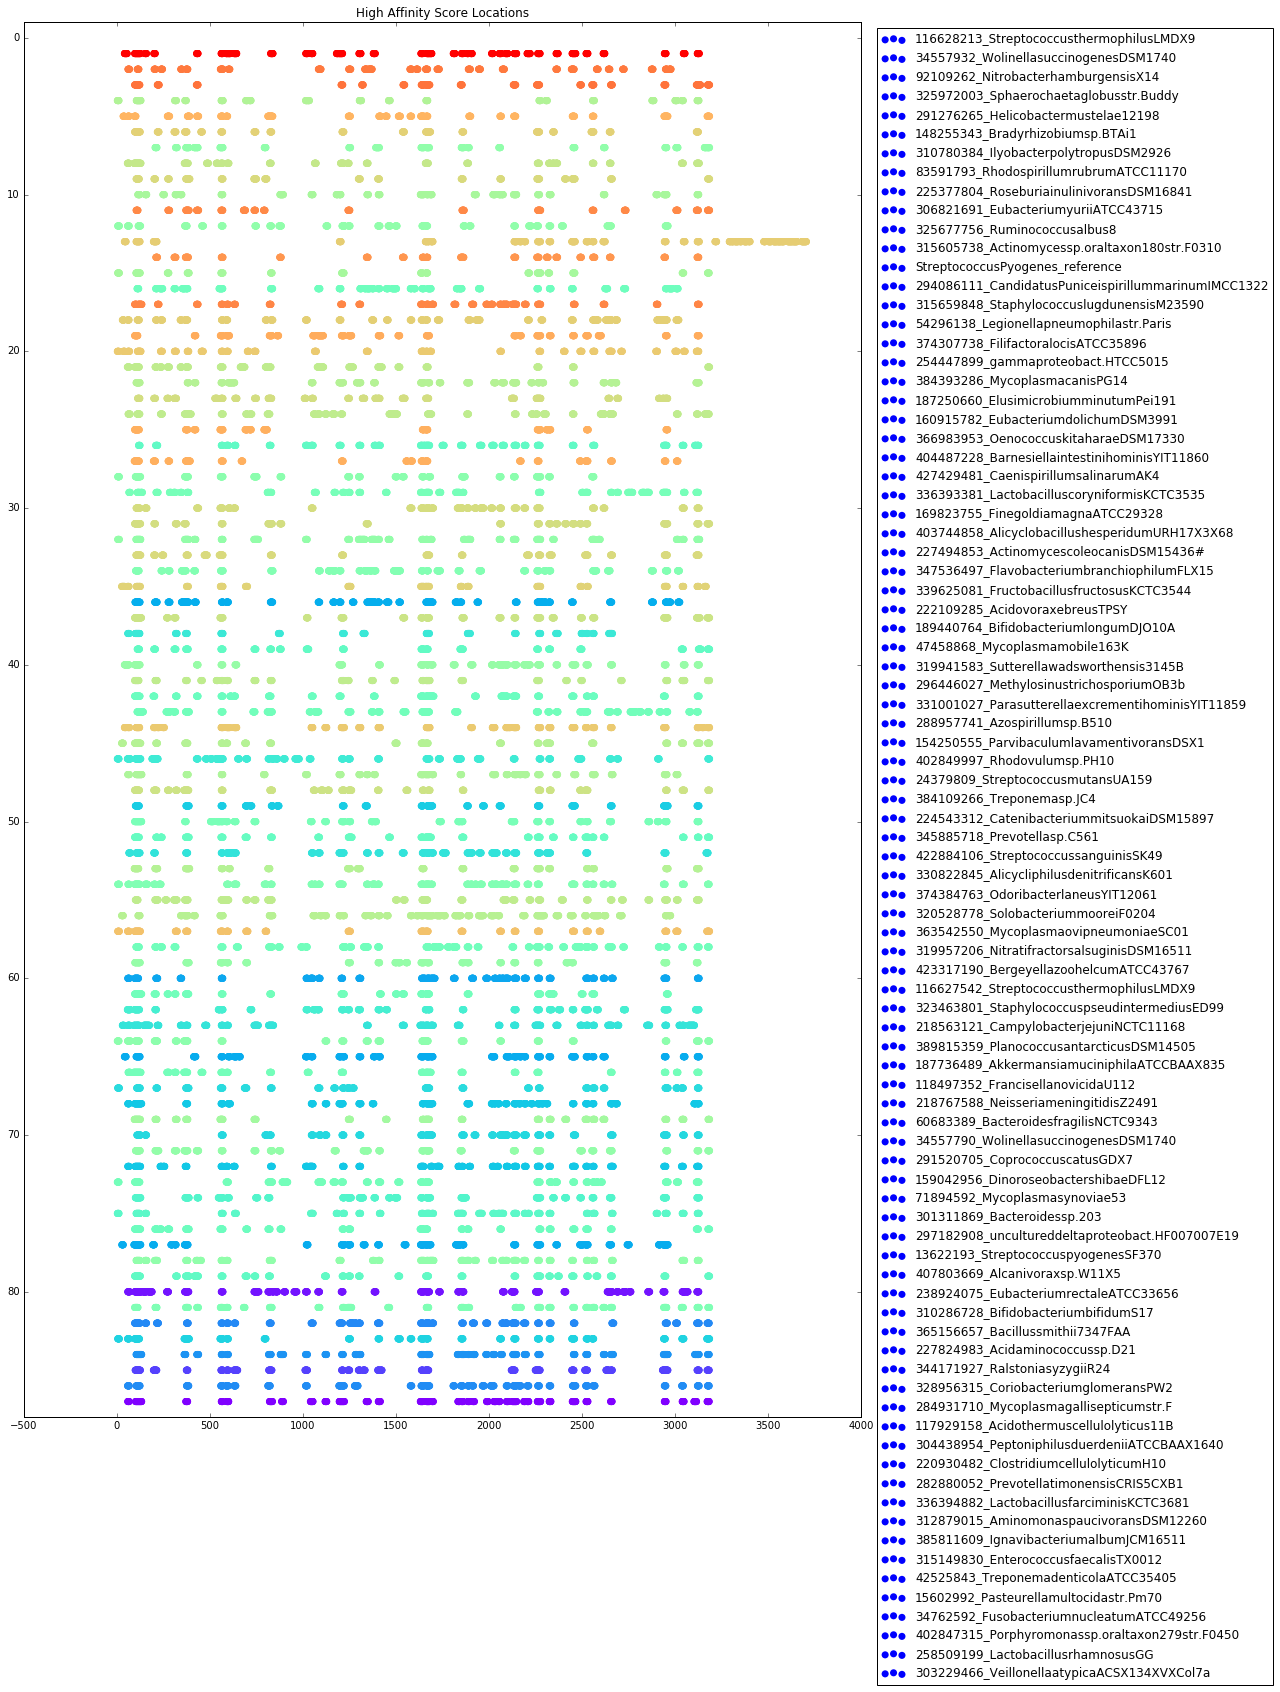

In [428]:
ranking_utils.plot_iterative_ranking_plot()

In [429]:
path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/ranked_iteratively.csv'
ranking_utils.iterative_ranking[['Proteins', 'Total Num Matches', 'Len High AA', 
                                 'Percentage Match To Self', 'Percentage Match To Prev']].to_csv(path_or_buf=path, sep=',')

In [232]:
color_dat = ranking_utils.iterative_ranking['Percentage Match To Prev'][1::].values.tolist()
color_dat.insert(0, 0)
color_list = _get_color_map(color_dat)

In [426]:
# import pandas
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nepitope import scoring_utils


class SimilartiyScore(object):

    def __init__(self, dataframe_list, fasta_file, reference_protein_id=None):

        self.df_list = dataframe_list
        self.fasta_file = fasta_file
        self.filtered_df = self._first_pass_filter()
        self.pos_list = self._retrieve_positions_list()
        self.ranges_list = self._retrieve_ranges_list()
        self.prot_list = self._get_protein_list()
        self.referece = self._get_ref_prot(reference_protein_id=reference_protein_id)
        self.matches = self._find_matches()
        self.num_matches = [len(i) for i in self.matches]
        self.total_matches = self._find_total_matches()
        self.num_total_matches = [len(i) for i in self.total_matches]
        self.columns = ['Proteins', 'Matches Positions', 'Total Num Matches', 'Ranges']
        self.rank_by_matches = self._get_df_ranked_by_matches()
        #self.ordered_list = 
        self.iterative_ranking = self.create_ranking_by_affiniy_location()

    ##############################################################################################
    # FUNCTIONS FOR ITERATIVE RANKING: These functions are aiming at creating the attribute      #
    # iterative_ranking and ordered_list. It works as follows:                                   #
    #  1. Select a protein that will be used 1st as a reference protein.                         #
    #  2. Calculate the number of 'Matches' (interpreted as number of High Affinity              #
    #     AA that share the same position) between reference protein and every other protein     #
    #  3. Append the one with lowest number of matches to a list (priority queue)                #
    #  4. The protein appended becomes the reference protein                                     #
    #  5. Repeat process with the appended protein, which is compared to all the other           #
    #     proteins (excluding the previous one).  Process goes on until every protein is ranked. #
    ##############################################################################################
    
    def create_ranking_by_affiniy_location(self):
        """
        :param reference_protein_id: to check the proper names of the protein IDs,
        check the attribute 'prot_list' by running SimilairtyScore.prot_list for
        a complete list.
        :return: list of of peptides ordered as defined above.
        """
        list_ordered = []
        base_df = self.rank_by_matches
        first_entry = self._get_first_entry(base_df, self.referece)
        list_ordered.append(first_entry)
        base_df = base_df[base_df.Proteins != self.referece]

        for i in range(len(base_df)):
            if i == 0:
                df = base_df
            else:
                df = remaining_data

            new_ref, remaining_ranges, remaining_prots = self._get_remaining_data(df.sort_values(by='Total Num Matches'))
            new_matches_list = self._find_total_matches_by_ref(new_ref[-1], remaining_ranges)
            num_new_matches = self._get_num_new_matches(new_matches_list)

            remaining_data = self._get_iterative_df_with_matches(remaining_prots, new_matches_list,
                                                                 num_new_matches, remaining_ranges)
            list_ordered.append(new_ref)
            
            df = self._get_ordered_list_into_pandas(list_ordered)
            df['Percentage Match To Self'] = pandas.Series(self._find_percentage_match(df))
            df['Percentage Match To Prev'] = pandas.Series(self._find_percentage_match_to_prev(df))
            
        return df.drop_duplicates(subset='Proteins')
        

    def _get_ordered_list_into_pandas(self, ordered_list):
        df =  pandas.DataFrame(ordered_list, columns=self.columns)
        return df

    def _get_remaining_data(self, df):
        return self._get_new_ref(df), self._get_remaining_ranges(df), self._get_remaining_proteins(df)

    @staticmethod
    def _get_first_entry(base_df, reference_protein_id):
        first_item =  base_df.loc[base_df['Proteins'] == reference_protein_id].values.tolist()[0]
        first_item[2] = 'All'
        return first_item
    
    @staticmethod
    def _get_num_new_matches(matches_list):
        return [len(i) for i in matches_list]

    @staticmethod
    def _get_new_ref(df):
        return df.head(1).values.tolist()[0]

    @staticmethod
    def _get_remaining_ranges(df):
        return df['Ranges'][1::].values.tolist()

    @staticmethod
    def _get_remaining_proteins(df):
        return df['Proteins'][1::].values.tolist()

    def _get_iterative_df_with_matches(self, remaining_prots, matches_positions, num_matches, ranges):

        data_ = [remaining_prots, matches_positions, num_matches, ranges]
        df = pandas.DataFrame(data_, index=self.columns)

        return df.T

    @staticmethod
    def _find_total_matches_by_ref(ref, remaining_ranges):

        ref_ranges = [item for sublist in ref for item in sublist]
        total_matches = []

        for range_list in remaining_ranges:
            comparison_ranges = [item for sublist in range_list for item in sublist]
            intersec_list = list(set(ref_ranges).intersection(set(comparison_ranges)))
            total_matches.append(intersec_list)

        return total_matches

    ################################################################################
    # FUNCTIONS FOR PLOTTING: Data to plotted are the peptide ranges per protein   #
    # methods available for affinity levels of selected protein against all others #
    # or for pairs of proteins.                                                    #
    ################################################################################

    def plot_affinity_regions(self):
        plot_data = self._retrieve_plot_data(self.ranges_list)
        protein_list = self.prot_list
        self.plotting_function(plot_data, protein_list)

    def plot_iterative_ranking_plot(self):
        to_plot = self._retrieve_plot_data(self.iterative_ranking.Ranges.values.tolist())
        protein_list = self.iterative_ranking.Proteins.values.tolist()
        color_data = self.iterative_ranking['Percentage Match To Prev'][1::].values.tolist()
        color_data.insert(0, 0.0)
        self.plotting_function(to_plot, protein_list, color_data)

    @staticmethod
    def _retrieve_plot_data(range_list):

        concatd_ranges_list = []
        for range_ in range_list:
            concatd_ranges_list.append(list(set([item for sublist in range_ for item in sublist])))

        to_plot = [[ranges, [i + 1] * len(ranges)] for i, ranges in enumerate(concatd_ranges_list)]

        return to_plot
    
    @staticmethod
    def _get_color_map(color_data, plot_data):

        color_list = []
        for i,color in enumerate(color_data):    

            interpolated_col = np.interp(color, [0, max(color_data)], [-1,1])
            full_list = np.full(len(plot_data[i][0]), interpolated_col)
            color_list.append(full_list)

        return color_list

    
    def plotting_function(self,  plot_data, prot_list, color_data):
        plt.figure(figsize=(15, 25))
        ax = plt.gca()
        ax.set_ylim([-1, len(prot_list) + 1])
        ax.invert_yaxis()
        plt.title('High Affinity Score Locations')
        #colors = cm.rainbow(np.linspace(0, 1, len(plot_data)))
        colors = self._get_color_map(color_data, plot_data) 
        for i, coordinate in enumerate(plot_data):
            plt.scatter(coordinate[0], coordinate[1], c=colors[i], linewidth='0', s=50, vmin=-1, vmax=1, label=prot_list[i], cmap='rainbow_r')
            # plt.scatter(coordinate[0], coordinate[1], color=colors, label=prot_list[i])

        plt.legend(bbox_to_anchor=(1.5, 1), loc=1, ncol=1)
        plt.show()


    
    ##############################################################################
    # FUNCTIONS TO RETRIEVE CLASS ATTRIBUTES: Mostly helper functions to get the #
    # shared data within the class.                                              #
    ##############################################################################

              
                  
    def _find_percentage_match(self, df):
       
        high_aa_count_list = self._high_aa_count(df)
        list_matches = df['Total Num Matches'][1::].values.tolist()
        percentage_list = [a/float(b) for a,b in zip(list_matches,high_aa_count_list)]
        percentage_list.insert(0, 100)
        
        return percentage_list
    
    def _find_percentage_match_to_prev(self, df):
     
        list_matches = df['Total Num Matches'][1::].values.tolist()
        ref = df['Len High AA'][:-1].values.tolist()
        percentage_to_ref_list = [a/float(b) for a,b in zip(list_matches,ref)]
        percentage_to_ref_list.insert(0, 100)
        
        return percentage_to_ref_list
    
    def _high_aa_count(self, df):

        df['Len High AA'] = df['Ranges'].apply(self._get_high_aa_count)
        return df['Len High AA'][1::].values.tolist()
    
    @staticmethod
    def _get_high_aa_count(x):
        ref_ranges = [item for sublist in x for item in sublist] #flatten
        return len(ref_ranges)
        
    
    def _get_ref_prot(self, reference_protein_id=None):
        if reference_protein_id:
            return reference_protein_id
        else:
            reference = [self.pos_list[0][j][0] for j in range(len(self.pos_list[0]))]
            return reference
    
    
    def _find_matches(self):
        matches = []
        ref = [self.pos_list[0][j][0] for j in range(len(self.pos_list[0]))]

        for i in range(1, len(self.pos_list)):
            yy = [self.pos_list[i][j][0] for j in range(len(self.pos_list[i]))]
            intersec_list = list(set(ref).intersection(set(yy)))

            # pos_list[i].append('Matches: ' + str(len(intersec_list)))
            matches.append(intersec_list)
            matches.append(list(set(ref).intersection(set(yy))))

        return matches

    def _find_total_matches(self):

        ref_ranges = [item for sublist in self.ranges_list[0] for item in sublist]
        total_matches = []

        for range_list in self.ranges_list:
            comparison_ranges = [item for sublist in range_list for item in sublist]
            intersec_list = list(set(ref_ranges).intersection(set(comparison_ranges)))
            total_matches.append(intersec_list)

        return total_matches

    def _get_df_ranked_by_matches(self):

        data_ = [self.prot_list, self.total_matches, self.num_total_matches, self.ranges_list]
        df = pandas.DataFrame(data_, index=['Proteins', 'Matches Positions', 'Total Num Matches', 'Ranges'])

        return df.T

    def _retrieve_ranges_list(self):

        ranges_list = []
        for single_list in self.pos_list:
            ranges_list.append([list(range(pos[0], pos[1] + 1)) for pos in single_list])

        return ranges_list

    def _first_pass_filter(self):
        
        filtered_dfs = []
        for i in self.df_list:
            filt_ = i.loc[i['Affinity Level'] == 'High']
            clean = self._return_clean(filt_)
            filtered_dfs.append(clean)

        return filtered_dfs

    
    def _fix_protein_name(self, prot_list):

        list_1, list_2 = scoring_utils.Score.create_separate_lists(self.fasta_file)
        truncated = prot_list
        
        for idx,name in enumerate(truncated):
            for j in list_1:
                if j[1:10] == name[0:9]:
                    truncated[idx] = j[1::]
                    
        return truncated
                    
    
    def _get_protein_list(self):
        
        prots = []
        for i in self.filtered_df:
            prots.append(i.ID.unique()[0])

        if len(prots) == len(self.df_list):
            return self._fix_protein_name(prots)

        else:
            prots = []
            for i in self.df_list:
                prots.append(i.ID.unique()[0])

            return self._fix_protein_name(prots)

    @staticmethod
    def _return_clean(df):
        df['Peptide'] = df['Peptide'].str.replace('X', '-')
        df = df.loc[df['Peptide'].str.contains('--') == False]
        return df

    def _retrieve_positions_list(self):
        _pos_ID = []
        for i in self.filtered_df:
            i['Final Pos'] = i['Pos'] + i['n-mer']
            i = i.sort_values(by='Pos')
            _pos_ID.append(i[['Pos', 'Final Pos']].values.tolist())

        return _pos_ID

    # def _plot_in_euclidean_space(some_lists)

    @staticmethod
    def _calc_min_dist(arr1, arr2):
        return min(product(arr1, arr2), key=lambda t: abs(t[0] - t[1]))

    @staticmethod
    def _pad_smaller_list(list_):
        threshold = 5
        for i in range(len(ls_2)):
            distance = ls_2[i] - ls_1[i]
            print(distance)
            if distance > threshold:
                ls_2.insert(i, 0)

In [209]:
np.full(1,7)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(1, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


array([ 7.])

In [10]:
for i, n in enumerate(lsss):
    prots.a[[enn.ID.unique())

In [10]:
_filt_test = _first_pass_filter(lsss)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
pos_list = _retrieve_positions_list(_filt_test)

In [11]:
xx = [pos_list[10][i] for i in range(len(pos_list[10]))]
print (xx)

[7, 26, 26, 55, 69, 71, 73, 80, 121, 124, 126, 127, 131, 133, 144, 153, 153, 159, 160, 210, 219, 221, 235, 235, 241, 243, 289, 299, 300, 309, 327, 327, 328, 391, 419, 421, 423, 433, 435, 451, 452, 453, 455, 457, 466, 469, 477, 480, 515, 521, 522, 522, 524, 528, 551, 551, 555, 560, 592, 601, 624, 625, 625, 638, 646, 659, 662, 663, 663, 663, 703, 704, 705, 729, 740, 799, 807, 816, 816, 825, 884, 961, 973, 991, 992, 992, 994, 998, 998, 1018, 1041, 1041, 1042, 1045, 1048, 1048, 1065, 1146, 1173, 1173, 1179, 1179, 1200, 1209, 1210, 1237, 1251, 1254, 1254, 1256, 1284, 1287, 1293, 1300, 1325, 1325, 1325, 1328, 1364, 1371, 1380]


In [15]:
pos_list =  _retrieve_positions_list(_filt_test)
ranges_list = _return_range(pos_list)

In [17]:
pos_list[0]

[[4, 13],
 [99, 109],
 [99, 108],
 [99, 107],
 [104, 115],
 [104, 113],
 [105, 116],
 [106, 116],
 [107, 116],
 [110, 119],
 [110, 118],
 [110, 120],
 [119, 127],
 [364, 372],
 [364, 373],
 [366, 377],
 [371, 381],
 [375, 384],
 [556, 565],
 [561, 570],
 [736, 746],
 [739, 750],
 [742, 753],
 [877, 886],
 [1241, 1251],
 [1299, 1308],
 [1496, 1506],
 [1534, 1544],
 [1640, 1650],
 [1675, 1686],
 [1678, 1686],
 [1854, 1863],
 [1863, 1872],
 [2055, 2065],
 [2132, 2141],
 [2256, 2266],
 [2262, 2271],
 [2265, 2274],
 [2268, 2278],
 [2268, 2278],
 [2321, 2330],
 [2553, 2564],
 [2553, 2564]]

In [172]:
concatd_ranges_list = []
for range_ in ranges_list:
    concatd_ranges_list.append(list(set([item for sublist in range_ for item in sublist])))
    #concatd_ranges_list.append([item for sublist in range_ for item in sublist])

In [178]:
to_plot = [[ranges, [i+1]*len(ranges)] for i, ranges in enumerate(concatd_ranges_list)]

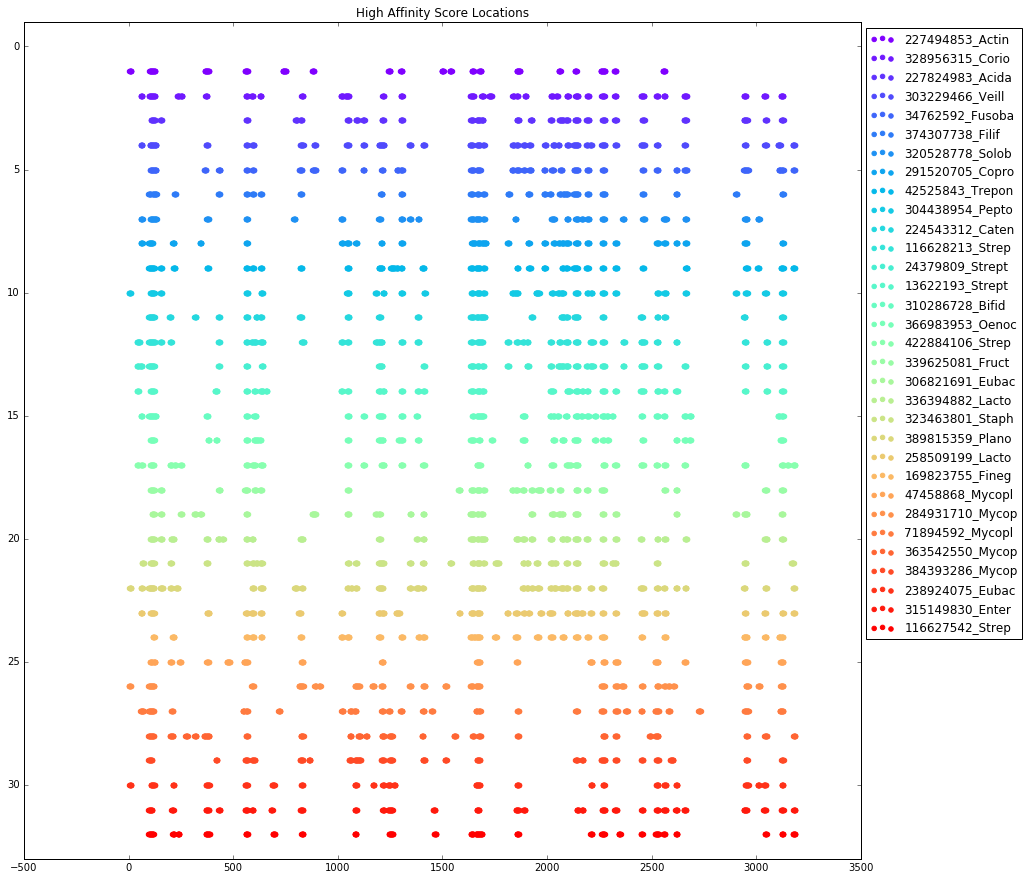

In [220]:
plt.figure(figsize=(15,15))
ax = plt.gca()
ax.set_ylim([-1,len(pos_list)+1])
ax.invert_yaxis()
plt.title('High Affinity Score Locations')
colors = cm.rainbow(np.linspace(0, 1, len(to_plot)))
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(to_plot))])

for i, coordinate in enumerate(to_plot):
        
        #data_to_plot.append([coordinate, [idx]*len(coordinate)])

    plt.scatter(coordinate[0], coordinate[1], color=colors[i], label=prots[i])
plt.legend(bbox_to_anchor=(1.2, 1), loc=1, ncol=1)



In [156]:
colormap(0)

(0.0, 0.0, 0.502, 1.0)

In [152]:
import numpy as np
colormap = plt.cm.gist_ncar
[colormap(i) for i in np.linspace(0, 0.9, 10)]

[(0.0, 0.0, 0.502, 1.0),
 (0.0, 0.053292967605985897, 0.80442695744964665, 1.0),
 (0.0, 0.93079686274509799, 1.0, 1.0),
 (0.0, 0.99184273675427614, 0.24580818269582871, 1.0),
 (0.45376078431372552, 0.91040322580645161, 0.0, 1.0),
 (0.85737517232758309, 1.0, 0.12482388288648784, 1.0),
 (1.0, 0.80664189435336953, 0.021098823529411777, 1.0),
 (1.0, 0.20513137254901981, 0.0, 1.0),
 (0.94626666666666648, 0.026863261296660175, 1.0, 1.0),
 (0.92631914648212221, 0.51834775086505169, 0.93650753556324495, 1.0)]

In [87]:
_calc_min_dist(pos_list[1], pos_list[2])

(7, 7)

In [72]:
pos_list = _retrieve_positions_list(_filt_test)

matches = []
ref = [pos_list[0][j][0] for j in range(len(pos_list[0]))]

for i in range(1, len(pos_list)):
    yy = [pos_list[i][j][0] for j in range(len(pos_list[i]))]
    intersec_list = list(set(ref).intersection(set(yy)))
    
    #pos_list[i].append('Matches: ' + str(len(intersec_list)))
    matches.append(intersec_list)

In [238]:
ref_ranges = [item for sublist in ranges_list[0] for item in sublist]


matches_2 = []
len_intersec = []

for range_list in ranges_list:
    comparison_ranges = [item for sublist in range_list for item in sublist]
    intersec_list = list(set(ref_ranges).intersection(set(comparison_ranges)))
    matches_2.append(intersec_list)
    len_intersec.append(len(intersec_list))
    

In [103]:
import sklearn.metrics as skl
skl.pairwise.cosine_similarity(pos_list[1][0:80], pos_list[4][0:80])

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.99950395]])

In [8]:
from itertools import product
selected_ref_protein_ID = 'BAV54120'


def create_ranking_by_affiniy_location(list_of_dfs):
    _list_filtered = _first_pass_filter(list_of_dfs)
    
     
def _first_pass_filter(list_of_dfs):
    filtered_dfs = []
    for i in list_of_dfs:
        filt_ = i.loc[i['Affinity Level'] == 'High']
        clean =_return_clean(filt_)
        filtered_dfs.append(clean)
        
    return filtered_dfs
    
def _return_clean(df):
    df['Peptide'] = df['Peptide'].str.replace('X', '-')
    df = df.loc[df['Peptide'].str.contains('--') == False]
    return df
    
    
def _retrieve_positions_list(list_of_dfs):
    _pos_ID = []
    for i in list_of_dfs:
        i['Final Pos'] = i['Pos'] + i['n-mer']
        i = i.sort_values(by='Pos')
        _pos_ID.append(i[['Pos', 'Final Pos']].values.tolist())
        
    return _pos_ID

def _return_range(_pos_ID_list):
    ranges_list = []
    for single_list in _pos_ID_list:

        ranges_list.append([list(range(pos[0], pos[1]+1)) for pos in single_list])
        
    return ranges_list
        

def _calc_min_dist(arr1, arr2):   
    return min(product(arr1, arr2), key=lambda t: abs(t[0]-t[1]))
    
def _pad_smaller_list(list_):
    threshold = 5
    for i in range(len(ls_2)):
        distance = ls_2[i] - ls_1[i]
        print(distance)
        if distance > threshold:
            ls_2.insert(i, 0)

#### Viz data in first protein

In [8]:
lsss[0].sort_values(by='nM').head(10) #Some high affinity peps in protein BAV54116

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer
7312,0.879,3.70,0.01,3609,EIIEQISEF,StreptococcusPy,HLA-A26:01,High,9
7309,0.847,5.21,0.12,3606,YLDEIIEQI,StreptococcusPy,HLA-A02:01,High,9
3292,0.843,5.44,0.03,3292,REVKVITL,StreptococcusPy,HLA-B40:01,High,8
5965,0.840,5.65,0.15,2262,SLLYEYFTV,StreptococcusPy,HLA-A02:01,High,9
6026,0.808,7.94,0.10,2323,KAIVXDLLF,StreptococcusPy,HLA-B58:01,High,9
2263,0.806,8.11,0.30,2263,LLYEYFTV,StreptococcusPy,HLA-A02:01,High,8
6918,0.804,8.34,0.03,3215,EVVKKMKNY,StreptococcusPy,HLA-A26:01,High,9
14482,0.797,8.94,0.03,3376,KYFFYSNIMNF,StreptococcusPy,HLA-A24:02,High,11
9271,0.794,9.34,0.07,1866,GEXXXLHAIL,StreptococcusPy,HLA-B40:01,High,10
9541,0.793,9.39,0.40,2136,ILTFRIPYYV,StreptococcusPy,HLA-A02:01,High,10


In [14]:
concatd = pandas.concat(lsss)

In [23]:
concatd.sort_values(by='Pos').head()

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer
0,0.043,31229.48,50.0,0,MDKKYSIG,StreptococcusPy,HLA-A01:01,No,8
11106,0.103,16493.98,32.0,0,MDKKYSIGLDI,StreptococcusPy,HLA-B15:01,No,11
7405,0.030,35946.07,50.0,0,MDKKYSIGLD,StreptococcusPy,HLA-B27:05,No,10
11106,0.065,24882.07,50.0,0,MDKKYSIGLDI,StreptococcusPy,HLA-B27:05,No,11
0,0.030,35946.07,50.0,0,MDKKYSIG,StreptococcusPy,HLA-A02:01,No,8


#### Add conservation scores

In [9]:
#scores_df.loc[(scores_df['n-mer'] == 11) & (scores_df['Score'] > 0) & (scores_df['Peptide'].str.contains('-') == False)]
#lsss[0]['n-mer'].unique()
#scores_df.loc[scores_df['n-mer']==11]

In [28]:
scores_and_affinity = scoring_utils.Score.add_conserv_score_to_df_list(lsss, scores_df)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1['Score'] = list_1


In [31]:
scores_and_affinity[0].loc[scores_and_affinity[0]['n-mer'] == 8].head(5)
# (Affinity Score U Cons Scorezx)

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer,Score
0,0.043,31229.48,50.0,0,MDKKYSIG,StreptococcusPy,HLA-A01:01,No,8,0.000000
1,0.043,31229.48,50.0,1,DKKYSIGL,StreptococcusPy,HLA-A01:01,No,8,0.000000
2,0.041,32085.75,50.0,2,KKYSIGLD,StreptococcusPy,HLA-A01:01,No,8,0.122423
3,0.053,28026.90,50.0,3,KYSIGLDI,StreptococcusPy,HLA-A01:01,No,8,0.197156
4,0.068,24087.38,32.0,4,YSIGLDIG,StreptococcusPy,HLA-A01:01,No,8,0.322156


In [12]:
## Save as csv
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/protein_data_per_peptide.csv'
scores_and_affinity[0].to_csv(path_or_buf=csv_path, sep=',')

# Data Summary
The class SummaryData has two classmethods: summarize_all_data, and summarize_protein data. 
The first takes as input the entire list of dataframes retrived from the previous steps, while the second takes that alongside with the accession ID of a protein of choice. 

The main method implemented alogside with the first classmethod is return_dataframe. It will return a dataframe that summarizes key information for each protein. 

With summarize_protein_data, summary information regarding a specific protein is retrieved. Methods for plotting conservation scores against affinity levels are also present.

The object single protein can be interrogated in a variety of manners:
Attributes of single_prot:

- my_protein (protein name)
- title (alignment title)
- high_affinity_peps (number of high affinity peptides)
- med_affinity_peps (number of intermediate affinity peptides)
- low_affinity_peps (number of low affinity peptides)
- no_affinity_peps (number of no affinity peptides)
- high_affinity_per_aa (num high affinity peptides per amino acid (protein length))
- length (protein length)
- single_hits (bumber of hits in blast alignemnt)

Most importantly, the class also has the attribute my_df, that is the original dataframe the contains the data for each specific peptide inside the protein. The data contained in it can also be used to generate useful plots.

Firstly, save raw summary data to csv. 

-------------------------------  ---------------
Accession ID                     StreptococcusPy
Num High Affinity Peps           23
Num Med Affinity Peps            110
Num Low Affinity Peps            352
Num No Affinity Peps             9823
Num High Affinity and Conserved  14
Num High Affinity Not Conserved  9
-------------------------------  ---------------


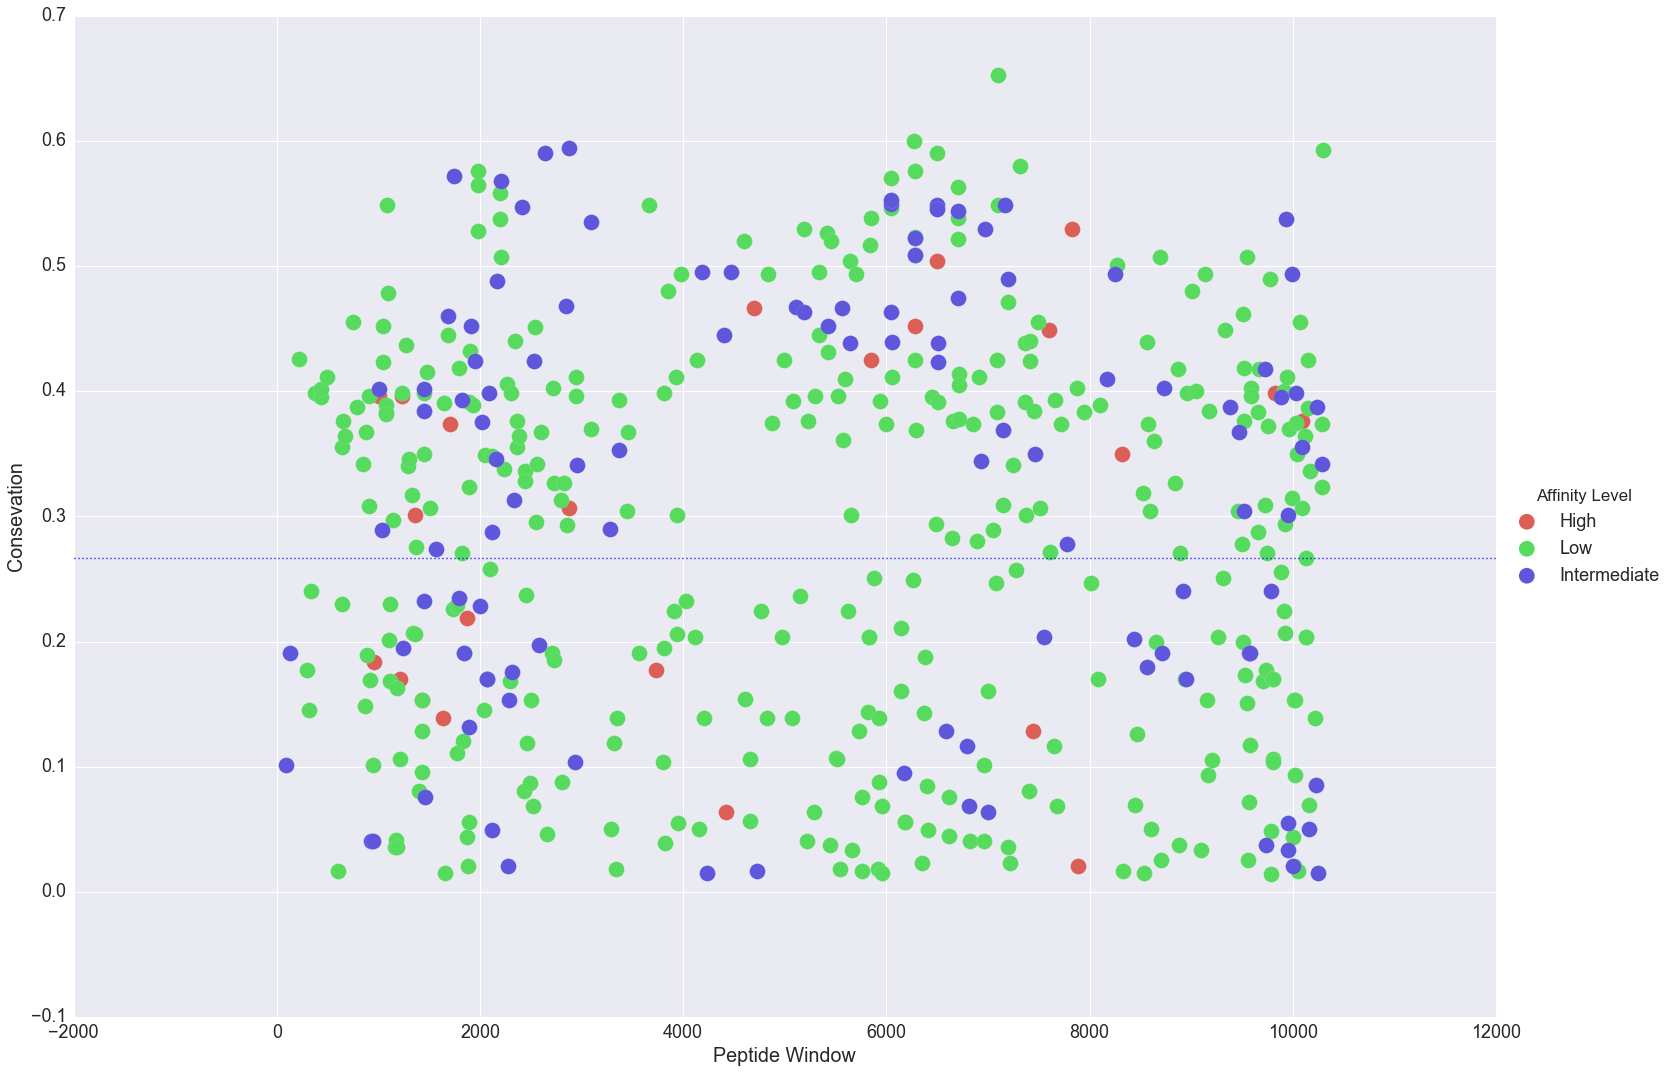

In [13]:
from nepitope import summary_data
%matplotlib inline

single_prot = summary_data.SummaryData.summarize_without_blast_dat(scores_and_affinity)
single_prot.plot_affinity_versus_conservation_score()
single_prot.print_table()
allele_list = single_prot.alleles

In [18]:
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/summary_protein_data_per_peptide.csv'
single_prot.my_df.to_csv(path_or_buf=csv_path, sep=',')

### The important part: add conservation alignment and high affinity peptide data   

In [13]:
msa_file = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2.fasta'
msa_file_out =  '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC_cons_AFFINITY_added.fasta'
positional_conservation = my_algn.positional_conservation
scores_affinity_df = scores_and_affinity[0]

msa_file_add_data = scoring_utils.AddData(msa_file, msa_file_out, scores_affinity_df, 
                                          positional_conservation, all_alleles=True)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:847: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_print['Peptide'] = to_print['Peptide'].str.replace('X', '-')


0.0


/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


0.0
0.0
0.0
0.04454384131
0.04454384131
0.0
0.0
0.0
0.0
0.0


In [14]:
msa_file_add_data.open_files()  ###should be renamed to open_and_write_to_msa. It indeed does both. 

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:847: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_print['Peptide'] = to_print['Peptide'].str.replace('X', '-')


### Transform in HTML file so that can be opened easily
Vizualise results in MSA alignment file

In [21]:
#ran from command line
mview -in fasta -ruler on -html head -coloring any /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC_cons_AFFINITY_added.fasta > /Users/carlomazzaferro/Documents/Code/clustal_study_cons_and_aff_added.html

SyntaxError: invalid syntax (<ipython-input-21-f055712b992b>, line 2)

In [126]:
import os
import webbrowser
from urllib import request

url = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_study_cons_and_aff_added.html")))

webbrowser.open(url)

True

>*Circles*: location of high conservation (on line: conservation info)

>*Peptides at the bottom*: location of high-affinity value

### Top 10 swap candidates and their analogues
Since we have the position of the high affinity, low conservation peptides, we can infer from them the potential peptides from other proteins likely to be good swaps. We'll do this by accessing the fasta file containing all protein sequeces. Further, to avoid false positives, we'll consider only Scores of 0 (or very close to 0).

In [15]:
high_aa_low_cons_df = msa_file_add_data.high_affinity_low_cons_df()
high_aa_low_cons_df

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer,Score
197,0.663,38.12,0.10,197,IVDEVA-Y,StreptococcusPy,HLA-A01:01,High,8,0.000000
4899,0.750,14.87,0.80,1196,-LFGNLIAL,StreptococcusPy,HLA-A02:01,High,9,0.000000
6226,0.661,38.96,1.50,2523,ILEDIVLTL,StreptococcusPy,HLA-A02:01,High,9,0.000000
9859,0.675,33.85,0.15,2454,GTYHDL-L-K,StreptococcusPy,HLA-A03:01,High,10,0.000000
2189,0.676,33.12,0.10,2189,ETITPWNF,StreptococcusPy,HLA-A26:01,High,8,0.000000
3899,0.673,34.40,0.12,196,NIVDEVA-Y,StreptococcusPy,HLA-A26:01,High,9,0.000000
6918,0.804,8.34,0.03,3215,EVVKKMKNY,StreptococcusPy,HLA-A26:01,High,9,0.000000
2141,0.672,34.77,0.40,2141,IPYYVGPL,StreptococcusPy,HLA-B07:02,High,8,0.063905
3743,0.702,25.27,0.30,40,-PSKKFKVL,StreptococcusPy,HLA-B07:02,High,9,0.000000
3743,0.667,36.71,0.15,40,-PSKKFKVL,StreptococcusPy,HLA-B08:01,High,9,0.000000


### Find similar peptides by doing simple AA swaps
The peptides will be written to a fasta file which will be sent to netMHCcons. Results will be analyzed subsequentially


In [17]:
from nepitope import pep_utils
fasta_files_dir = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/swapping_fasta_files/'
pep_utils.find_swaps_write_to_fasta(high_aa_low_cons_df, fasta_files_dir)

### Load Results From netMHCcons

In [19]:
from nepitope import scoring_utils, summary_data
import glob
nmers = [8, 9,10,11]

#files saved from netMHCcons as split_*i*_prediction_*n*_mer for each split/nmer
filepath = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/swapping_fasta_files/swapping_preds/'

file_pattern = '_swap_*'

aggregate_all = scoring_utils.FileConsolidation.load_batch(filepath, file_pattern)

files = glob.glob('/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/swapping_fasta_files/swapping_preds/_s*')
original_peps_and_pos = []

for file in files:
    split_ = file.split('/')[-1]
    split_2 = split_.split('_')
    original_peps_and_pos.append([split_2[2], split_2[4]])

### Return them in a list of dataframes

In [20]:
list_results = aggregate_all.return_df_list()

In [22]:
summ_data = summary_data.SummaryData()
summ_data_analysis = summ_data.summarize_data_for_each_mhc_pred(list_results, original_peps_and_pos, high_aa_low_cons_df)

### Return summary data in a dataframe
Other methods and attributes are present as well

In [46]:
list(summ_data_analysis.summary_df.loc[summ_data_analysis.summary_df['original peptide'] == 'HHQDLTLL']['top scoring peptides'])

[['HHQDLTLK',
  'HHQDLTLN',
  'HHQDLTLD',
  'HHQDLTLR',
  'HHQDLTLG',
  'HHQDLTLH',
  'HHQDLTLE',
  'HHQDLTLY',
  'HHQDLTLQ',
  'HGQDLTLL',
  'PHQDLTLL',
  'HWQDLTLL',
  'HHQDLTLS',
  'HTQDLTLL',
  'HHQDLTLT',
  'HHQDLTLW',
  'HHQDLTLC',
  'HSQDLTLL',
  'HLQDLTLL',
  'GHQDLTLL',
  'HVQDLTLL',
  'HNQDLTLL',
  'HHQDLTLP',
  'DHQDLTLL',
  'HCQDLTLL',
  'KHQDLTLL',
  'HEQDLTLL',
  'HIQDLTLL',
  'HHQDLTLA',
  'HHQDLTLF',
  'HAQDLTLL',
  'IHQDLTLL']]

### Write files out

In [25]:
fasta_dir = '/Users/carlomazzaferro/Desktop/fasta_swaps_top_20_percent.fasta'
summ_data_analysis.write_peptides_to_fasta(fasta_dir)

In [32]:
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/summary_results_per_prediction.csv'
summ_data_analysis.summary_df.sort_values(by='original pos').to_csv(path_or_buf=csv_path, sep=',')

In [43]:
basepath = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/csv_for_each_prediction/'
for idx, val in enumerate(list_results):
    original_pep = original_peps_and_pos[idx][0]
    pos = original_peps_and_pos[idx][1]
    allele = val.Allele.unique()[0]
    nmer = val['n-mer'].unique()[0]
    name = "_".join([original_pep, pos, allele, str(nmer)])
    val['Peptide'] = val['Peptide'].str.replace('X', '-')
    write_to_csv(val, basepath + name + '.csv')
    

In [36]:
def write_to_csv(df, path_name):
    df.to_csv(path_name, sep=',')
    